# Predicting Car Prices

## Introduction

## Problem Definition

## Data Collection

In [ ]:
%pip install xgboost

In [29]:
# Importing the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


# Note: If you need TargetEncoder, install and import from category_encoders:
from category_encoders import TargetEncoder
# If you need FreqDistEncoder, please specify the package or provide the implementation.


## Loading the dataset



In [30]:
# load the train dataset as pandas dataframe

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')


In [ ]:
train_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            125690 non-null  int64 
 1   brand         125690 non-null  object
 2   model         125690 non-null  object
 3   model_year    125690 non-null  int64 
 4   milage        125690 non-null  int64 
 5   fuel_type     122307 non-null  object
 6   engine        125690 non-null  object
 7   transmission  125690 non-null  object
 8   ext_col       125690 non-null  object
 9   int_col       125690 non-null  object
 10  accident      124058 non-null  object
 11  clean_title   111451 non-null  object
dtypes: int64(3), object(9)
memory usage: 11.5+ MB


In [32]:
train_df.isnull().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

## Exploratory Data Analysis

### Univariate Analysis

---

#### Brand



There are 57 unique car brands in the dataset.


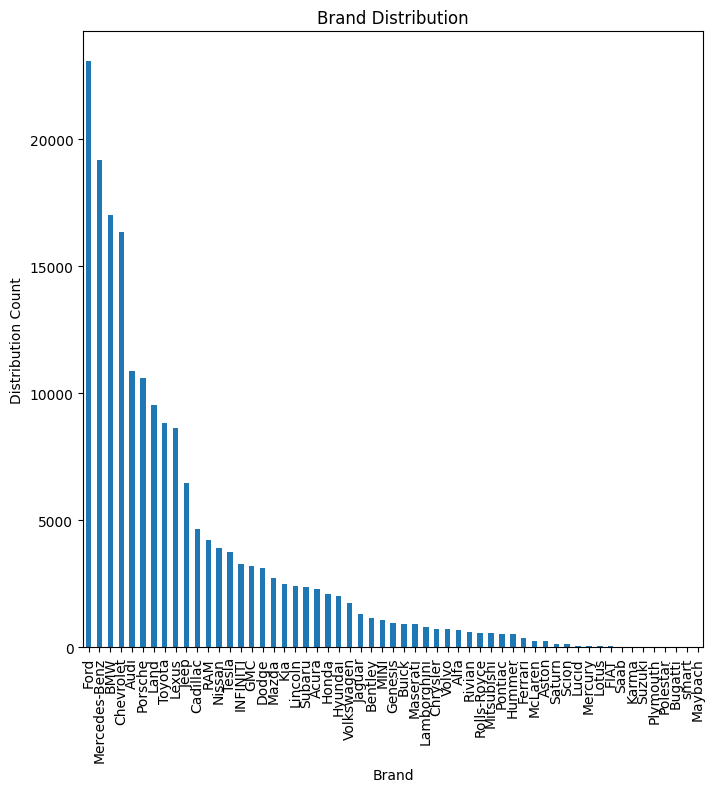

In [33]:
train_df['brand'].value_counts().plot(kind= 'bar', figsize=(8,8), 
                                      title='Brand Distribution', 
                                      xlabel= 'Brand', 
                                      ylabel= 'Distribution Count')

print(f'There are {train_df['brand'].nunique()} unique car brands in the dataset.')

In [34]:

def plot_categorical_distribution(column):
    
    """Function to plot the distribution of a categorical column
    """
    
    plt.figure(figsize=(10,6))
    sns.countplot(data=train_df, x=column, order=train_df[column].value_counts().index)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
    print(f'There are {train_df[column].nunique()} unique {column}s in the dataset.')

#### Fuel Type

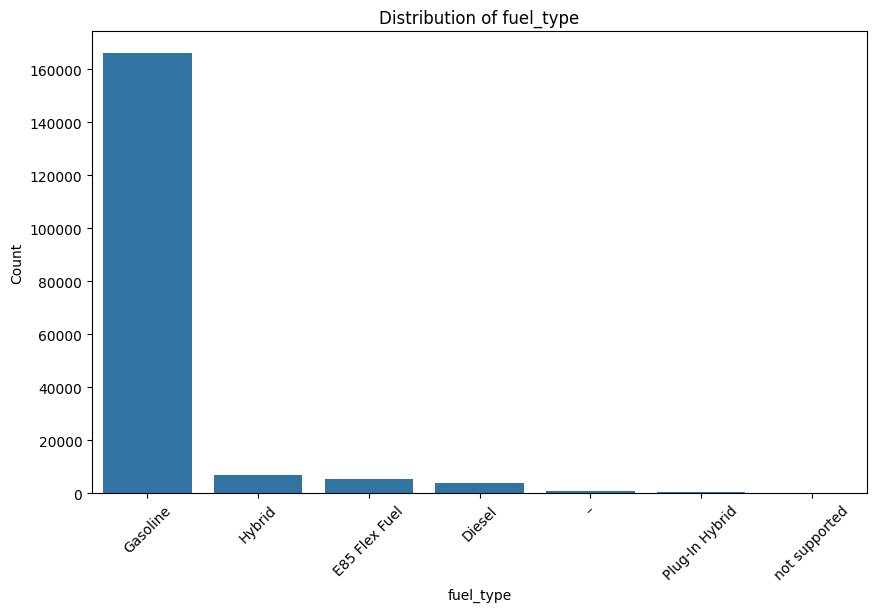

There are 7 unique fuel_types in the dataset.


In [35]:
plot_categorical_distribution('fuel_type')

#### Model Year

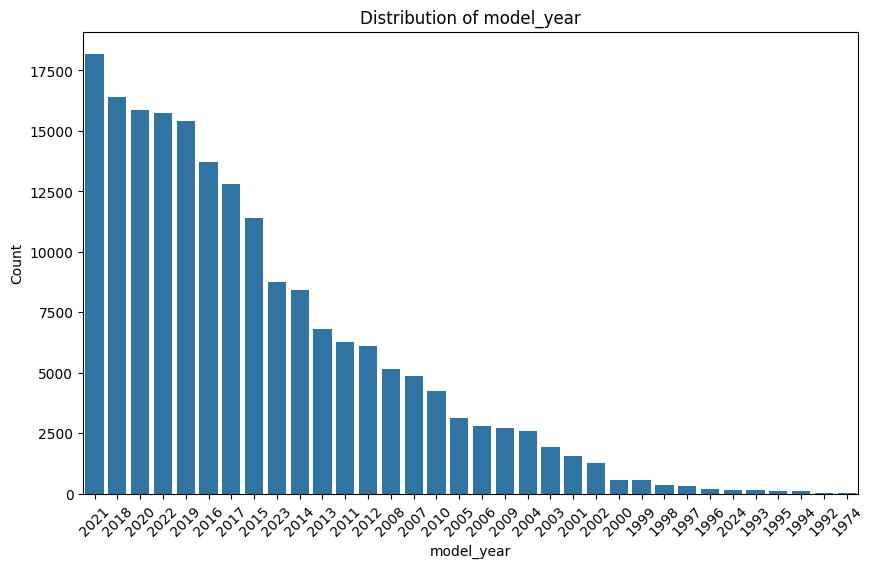

There are 34 unique model_years in the dataset.


In [36]:
plot_categorical_distribution('model_year')

#### Exterior Color

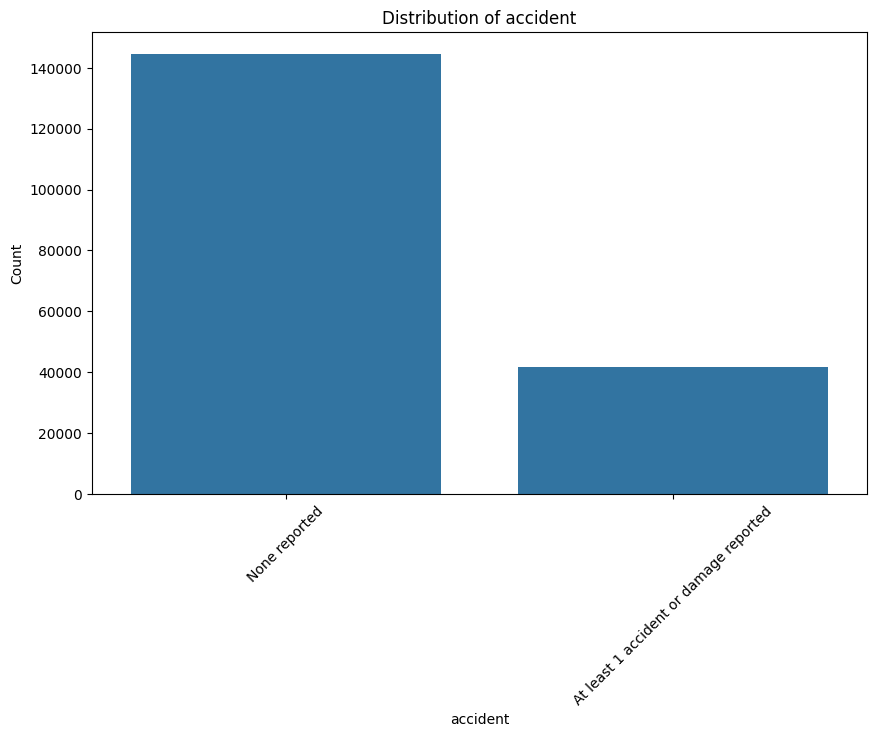

There are 2 unique accidents in the dataset.


In [37]:
plot_categorical_distribution('accident')

#### Transmission

In [38]:
train_df['transmission'].value_counts()

transmission
A/T                                                   49904
8-Speed A/T                                           20645
Transmission w/Dual Shift Mode                        19255
6-Speed A/T                                           18044
6-Speed M/T                                           11998
7-Speed A/T                                           11124
Automatic                                             10691
8-Speed Automatic                                      8431
10-Speed A/T                                           8044
9-Speed A/T                                            3866
5-Speed A/T                                            3217
10-Speed Automatic                                     3164
6-Speed Automatic                                      2799
4-Speed A/T                                            2546
5-Speed M/T                                            2409
9-Speed Automatic                                      2325
CVT Transmission           

In [39]:
# clean up the transmission column into atutomatic and manual transmission only.

# Write a function to clean the transmission column


# Define mapping logic
def classify_transmission(value):
    value = str(value).lower()
    if "manual" in value or "m/t" in value:
        return "M/T"
    elif "automatic" in value or "a/t" in value or "auto-shift" in value or "cvt" in value:
        return "A/T"
    elif "speed" in value:
        if "m/t" in value or "manual" in value:
            return "M/T"
        else:
            return "A/T"
    else:
        return "Unknown"  # Optional: handle edge cases

# Apply classification
train_df['transmission'] = train_df['transmission'].apply(classify_transmission)

# Optional: Check results
print(train_df['transmission'].value_counts())



transmission
A/T        152449
Unknown     19726
M/T         16358
Name: count, dtype: int64


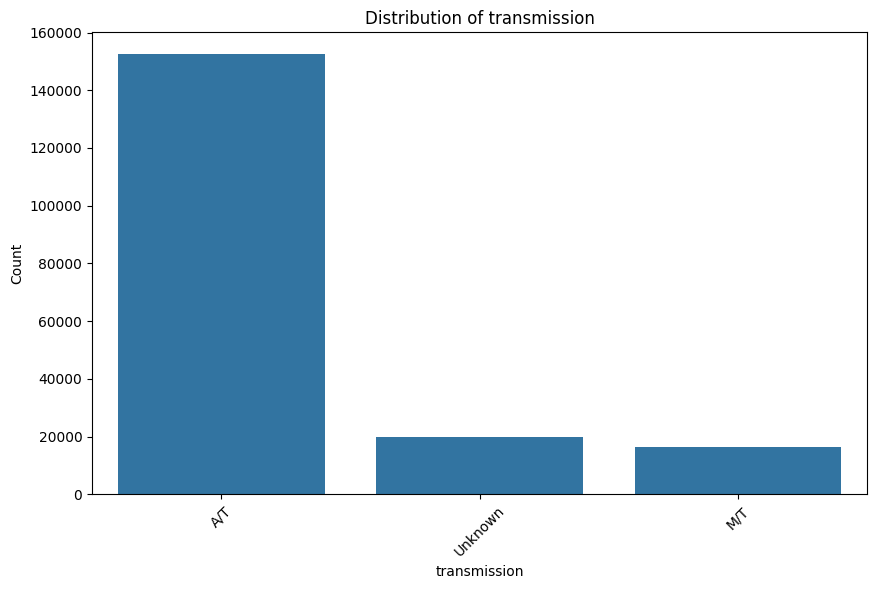

There are 3 unique transmissions in the dataset.


In [40]:
plot_categorical_distribution('transmission')

In [41]:
train_df.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

## Data Preprocessing

### Handling Missing Values

#### Columns with missing values

1. fuel_type (cat)
2. accident (cat)
3. clean_title (cat)

In [42]:
# Handle missing values in train_df

# Create a function to handle missing values 

def handle_missing_values(df):
    # For categorical columns, fill missing values with the mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df[col].fillna('missing', inplace=True)
    
    # For numerical columns, fill missing values with the median
    numerical_cols = df.select_dtypes(include=['number']).columns
    for col in numerical_cols:
        df[col].fillna(df[col].median(), inplace=True)
    
    return df

In [43]:
train_df = handle_missing_values(train_df)
test_df = handle_missing_values(test_df)

### Encode Categorical Variables

Which encoder to use?

* get_dummies()
* OneHotEncoder()
* LabelEncoder()

I am using TargetEncoder here because LabelEncoder works better for target vairables in a classification task.

In [44]:
# Encode categorical variables using OneHotEncoder

# Identify categorical and numerical columns
low_cardinality_categorical_cols = ['brand', 'fuel_type', 'transmission', 'accident', 'clean_title', 'ext_col', 'int_col'] #Label Encoding
high_cardinality_categorical_cols = ['model', 'engine'] # Target Encoding
numerical_cols = ['model_year', 'mileage', 'price']


# Label Encoding for low cardinality categorical columns
le = LabelEncoder()

def label_encode_columns(df, columns):
    for col in columns:
        df[col] = le.fit_transform(df[col])
    return df

# Target Encoding for high cardinality categorical columns

def target_encode_columns(train, test, high_cardinality_categorical_cols, target):
    
    te = TargetEncoder(cols=high_cardinality_categorical_cols, smoothing=1)
    
    train_df_encoded = te.fit_transform(train, target)
    test_df_encoded = te.transform(test)
        
        
    return train_df_encoded, test_df_encoded


In [45]:
# Apply classification
test_df['transmission'] = test_df['transmission'].apply(classify_transmission)

# Optional: Check results
print(test_df['transmission'].value_counts())


transmission
A/T        101744
Unknown     13161
M/T         10785
Name: count, dtype: int64


## Feature Selection/Engineering

In [46]:
X = train_df.drop(['price', 'id'], axis=1) # Replace 'price' with your target column name
y = train_df['price']

X_test = test_df.drop(['id'], axis=1)

In [48]:
X_test = label_encode_columns(X_test, low_cardinality_categorical_cols)
X = label_encode_columns(X, low_cardinality_categorical_cols)


train_df, test_df = target_encode_columns(X, X_test, high_cardinality_categorical_cols, y)

## Train-Test Split

In [49]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_val, y_train, y_val = train_test_split(train_df, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {len(X_train)}")
print(f"Testing set size: {len(X_val)}")


Training set size: 150826
Testing set size: 37707


## Model Initialization and Training

### with Grid Search

In [50]:
def train_with_cv(estimator, param_grid, X, y, cv_splits=5, scoring=None):
    """
    Perform K-Fold Cross Validation with hyperparameter tuning. Adjust params as you please

    Parameters:
    estimator : sklearn estimator
        The model to train (e.g., RandomForestRegressor(), LogisticRegression(), etc.)
    param_grid : dict
        Hyperparameter search space, e.g., {'n_estimators': [100, 200], 'max_depth': [5, 10]}
    X : Features
    y : Target variable
    cv_splits : int
        Number of folds for cross-validation
    scoring : str or callable
        Scoring metric (default: neg_root_mean_squared_error for regression)
    """
    # default scoring = RMSE for regression
    if scoring is None:
        scoring = make_scorer(root_mean_squared_error, squared=False)

    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=kfold,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X, y)

    return grid_search.best_estimator_, grid_search.best_params_, grid_search.cv_results_

In [ ]:
model=RandomForestRegressor()
#model.fit(X_train,y_train)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

best_model, best_params, cv_results = train_with_cv(model, param_grid, X_train, y_train)

print("Best Params:", best_params)

### using xgboost

In [51]:
from xgboost import XGBRegressor


model = XGBRegressor()

# model=RandomForestRegressor()
#model.fit(X_train,y_train)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'gamma': [0, 0.5]
}

best_model, best_params, cv_results = train_with_cv(model, param_grid, X_train, y_train)

print("Best Params:", best_params)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Params: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}


In [52]:
y_val_pred = best_model.predict(X_val)

val_rmse = root_mean_squared_error(y_val, y_val_pred)


print("Validation RMSE:", val_rmse)


Validation RMSE: 70957.8984375


#### Feature importance

<Axes: ylabel='None'>

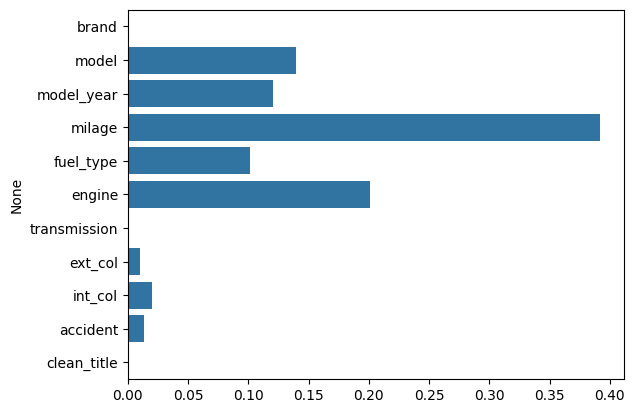

In [53]:
sns.barplot(y=X_train.columns, x=best_model.feature_importances_, orient='y')

In [55]:
final_model = XGBRegressor(**best_params,random_state=42)

final_model.fit(
    np.vstack([X_train, X_val]), 
    np.hstack([y_train, y_val])
)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [56]:
y_test_pred = final_model.predict(test_df)
y_test_pred[:5]

array([32860.977, 58288.65 , 50202.863, 40146.57 , 40202.906],
      dtype=float32)

In [57]:
test =pd.read_csv('test.csv')

submission=pd.DataFrame({"id":test['id'],"Price":y_test_pred})
submission.to_csv("Submissions.csv",index=False)

### with Randomized Search

In [66]:
def train_with_cv_random_search(estimator, param_dist, X, y, cv_splits=5, scoring=None):
    """
    Perform K-Fold Cross Validation with hyperparameter tuning. Adjust params as you please

    Parameters:
    estimator : sklearn estimator
        The model to train (e.g., RandomForestRegressor(), LogisticRegression(), etc.)
    param_grid : dict
        Hyperparameter search space, e.g., {'n_estimators': [100, 200], 'max_depth': [5, 10]}
    X : Features
    y : Target variable
    cv_splits : int
        Number of folds for cross-validation
    scoring : str or callable
        Scoring metric (default: neg_root_mean_squared_error for regression)
    """
    # default scoring = RMSE for regression
    if scoring is None:
        scoring = make_scorer(root_mean_squared_error, squared=False)

    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=42)

    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_dist,
        cv=kfold,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )

    random_search.fit(X, y)

    return random_search.best_estimator_, random_search.best_params_, random_search.cv_results_

In [71]:
model=RandomForestRegressor()
#model.fit(X_train,y_train)
param_dist = {
    'n_estimators': range(900, 1000),
    'max_depth': [None] + list(range(10, 50)),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 5),
    'max_features': ['auto', 'sqrt', 'log2']
}

best_model, best_params, cv_results = train_with_cv_random_search(model, param_dist, X_train, y_train)

print("Best Params:", best_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Params: {'n_estimators': 915, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 17}


In [72]:
y_val_pred = best_model.predict(X_val)

val_rmse = root_mean_squared_error(y_val, y_val_pred)

print("Validation RMSE:", val_rmse)

Validation RMSE: 67868.17200805224


#### Feature importance



<Axes: ylabel='None'>

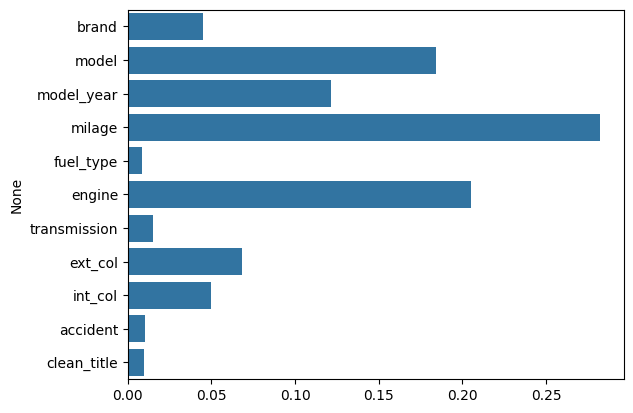

In [73]:

sns.barplot(y=X_train.columns, x=best_model.feature_importances_, orient='y')

In [74]:

final_model = RandomForestRegressor(**best_params,random_state=42)

final_model.fit(
    np.vstack([X_train, X_val]), 
    np.hstack([y_train, y_val])
)

,n_estimators,915
,criterion,'squared_error'
,max_depth,17
,min_samples_split,5
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [75]:
y_test_pred = final_model.predict(test_df)
y_test_pred[:5]

array([17282.68737523, 88529.14146178, 55005.65219609, 28196.97869627,
       30351.73261158])

In [76]:

test =pd.read_csv('test.csv')

submission=pd.DataFrame({"id":test['id'],"Price":y_test_pred})
submission.to_csv("Submissions.csv",index=False)

In [70]:
train_df.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title'],
      dtype='object')